# Final Project
## AIM-5014-1A: Experimental Optimization
## David Sweet


This is a group project.

You are a team of AI engineers responsible for the well-being of a chatbot. Each day you receive a measurement of user satisfaction. It is a noisy number between 0 and 100, and it is your business metric.

After viewing the business metric, you may adjust three configuration parameters that affect the way the system operates and, in turn, the level of user satisfaction.

For this project, you will experimentally optimize the chatbot. You will adjust the configuration parameters to maximize user satisfaction.

## Measurements

The measurements are provided by a server running at [http://44.202.108.53:8080](http://44.202.108.53:8080).  

The parameters are represented by a vector, $x$, which has three components. Each component must lie in $[0,1]$, i.e., $x_i \in [0,1]$.

To take a measurement, you need to know your group id (called `sid`) and the parameters you want to measure (called `x`). For example, say your group id is 123 and want to measure $x = [0.1, 0.2, 0.3]$. You would visit the url

http://44.202.108.53:8080/?sid=123&x=0.1,0.2,0.3

Note that the x values are separated by commas.

You only get to take one measurement/day.

## Group ID: 31415
## Group Members:

- Marwan Kanaan
- Haris Sumra
- Haider Ali
- Sai Lalitesh

## Notes

You will learn useful techniques for solving this problem in the coming weeks, but since you only get one measurement/day, time is of the essence.

If you'd like to get a headstart, take a look at these Bayesian optimization tools:

- http://cogneato.xyz
- https://ax.dev
- https://scikit-optimize.github.io/stable/


### **Objective**: Improving customer satisfaction (Y) by accurately setting parameters X1, X2, and X3 of the Chatbot model.

The effectiveness of a chatbot is intricately linked to the satisfaction and overall experience of its users. Therefore, measuring user satisfaction stands as a fundamental business metric for evaluating the chatbot's performance. User satisfaction serves as a direct reflection of how effectively the chatbot meets users' needs and expectations. Notably, achieving a high level of user satisfaction fosters greater customer loyalty, ultimately bolstering the chatbot's success in delivering valuable interactions and building lasting relationships with users.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    "x1": [0.99, 0.5, 0.1, 0.292148, 0.470537, 0.5,0.772, 0.65, 0.561, 0.603, 0.581, 0.631, 0.555, 0.564, 0.614, 0.635, 0.409, 0.623, 0.442, 0.446, 0.50530835],
    "x2": [0.99, 0.5, 0.1, 0.91634, 0.1, 0.5,0.285, 0.421, 0.395, 0.392, 0.509, 0.316, 0.441, 0.41, 0.413, 0.412, 0.4, 0.409, 0.485, 0.286, 0.43740641	],
    "x3": [0.99, 0.5, 0.1, 0.366324, 0.489081, 0.1,0.824, 0.682, 0.767, 0.561, 0.74, 0.825, 0.702, 0.759, 0.587, 0.879, 0.731, 0.705, 0.766, 0.76, 0.81043053],
    "y": [91.44413421440021, 101.75116478560905, 93.72515688462597, 90.34559275813045, 90.6892674675357, 97.00782577467955,101.82866585050124, 103.5472167, 102.63506618077,
          99.67889311, 100.0146109, 98.71722436, 94.7809451, 103.5302942, 101.5081597, 99.66232628, 99.66928186, 96.94311708, 102.0103643, 98.32962999, 102.149349]
})

df

,x1,x2,x3,y
0,0.990000,0.990000,0.990000,91.444134
1,0.500000,0.500000,0.500000,101.751165
2,0.100000,0.100000,0.100000,93.725157
3,0.292148,0.916340,0.366324,90.345593
4,0.470537,0.100000,0.489081,90.689267
5,0.500000,0.500000,0.100000,97.007826
6,0.772000,0.285000,0.824000,101.828666
7,0.650000,0.421000,0.682000,103.547217
8,0.561000,0.395000,0.767000,102.635066
9,0.603000,0.392000,0.561000,99.678893


In [2]:
df.describe()

,x1,x2,x3,y
count,21.000000,21.000000,21.000000,21.000000
mean,0.544952,0.434178,0.649706,98.569918
std,0.173829,0.205750,0.231622,4.178279
min,0.100000,0.100000,0.100000,90.345593
25%,0.470537,0.392000,0.561000,96.943117
50%,0.561000,0.412000,0.731000,99.669282
75%,0.623000,0.485000,0.767000,101.828666
max,0.990000,0.990000,0.990000,103.547217


# Measurement analysis

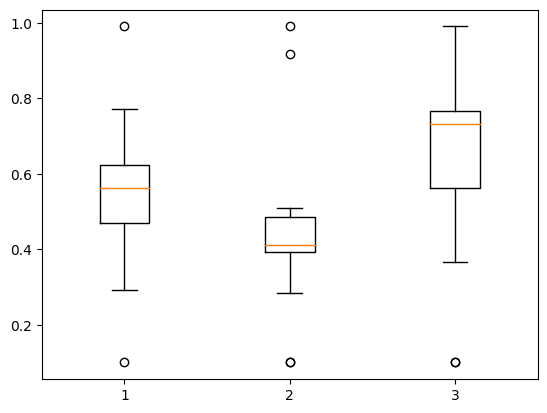

In [3]:
plt.boxplot([df.x1, df.x2, df.x3]);

In [4]:
import plotly.express as px
fig = px.scatter_3d(df, x='x1', y='x3', z='y',
              color='y')
fig.show()

# Initialization

We spread the first measurements out in the parameters space. Here, we have 3 a vector with 3 dimensions.

In [5]:
x_start = [0.5,0.5,0.5]

We use Cogneato to optimize the acquisition function which is the Upper Confidence Bound (UCB) of the surrogate.

# Measure at Parameter

Link to the measurements: https://docs.google.com/spreadsheets/d/10a9qqRZ-Wfu4aHxfSTL1ZiWR1chIhrYwgf-A8PZaOFg/edit?usp=sharing

Each row of the table corresponds to a round of measurements. Indeed, the system was sending us one measurement each 24 hours for the three variables as input.

______

# Analyze: Model Response Surface w/ GPR

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Input data for x0, x1, x2, and y_mean
X = df.drop("y", axis=1).to_numpy()
y_mean = df.y.to_numpy()

# Create the Gaussian Process Regression model
surrogate = GaussianProcessRegressor(kernel=RBF(), n_restarts_optimizer=20)

# Fit the model to the data
surrogate.fit(X, y_mean)

GaussianProcessRegressor(kernel=RBF(length_scale=1), n_restarts_optimizer=20)

# Design: Optimize Acquisition Function

In [7]:
from scipy.optimize import minimize

# Define the UCB function
def ucb(x, model, beta):
    mean, std = model.predict(x.reshape(1, -1), return_std=True)
    return -(mean + beta * std)  # Minimize the negative UCB to maximize the UCB

# Set the value of beta (controls exploration-exploitation trade-off)
beta = 2

# Set the bounds for the parameters (x0, x1, x2)
bounds = [(0, 1), (0, 1), (0, 1)]

# Optimize the UCB function using the GPR model
result = minimize(ucb, x0=[0.5, 0.5, 0.5], args=(surrogate, beta), bounds=bounds)

# Get the optimal parameters that maximize the UCB function
optimal_params = result.x

# Evaluate the actual objective function to get the corresponding y_mean and y_se (if needed)
y_mean_optimal, y_std_optimal = surrogate.predict(np.array([optimal_params]), return_std=True)

print("Optimal Parameters:", optimal_params)
print("Optimal UCB Value:", -result.fun)  # Convert back to maximize the UCB function
print("Corresponding y_mean at Optimal Point:", y_mean_optimal[0])
print("Corresponding y_std at Optimal Point:", y_std_optimal[0])


Optimal Parameters: [0.5966487  0.45301963 0.52325375]
Optimal UCB Value: 112.1895375400817
Corresponding y_mean at Optimal Point: 111.55632110091709
Corresponding y_std at Optimal Point: 0.3166082195823075


# Finding optimal parameter using all the combinations for X variables.

In [8]:
# Define a grid of parameters to try
x0_values = np.linspace(0, 1, 20) 
x1_values = np.linspace(0, 1, 20) 
x2_values = np.linspace(0, 1, 20)

In [9]:
# Initialize optimial parameters
optimal_params = None
optimal_ucb_value = float('-inf')

In [10]:
# Importing progress library
from tqdm import tqdm
# Loop through all combinations of parameters
for x0 in tqdm(x0_values):
    for x1 in x1_values:
        for x2 in x2_values:
            x = np.array([x0, x1, x2])
            result = minimize(ucb, x0=x, args=(surrogate, beta), bounds=bounds)
            ucb_value = -result.fun

            if ucb_value > optimal_ucb_value:
                optimal_ucb_value = ucb_value
                optimal_params = result.x

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [11:40<00:00, 35.05s/it]


In [13]:
# Evaluate the actual objective function at the optimal point to get the corresponding y_mean and y_std (if needed)
y_mean_optimal, y_std_optimal = surrogate.predict(np.array([optimal_params]), return_std=True)

print("Optimal Parameters:", optimal_params)
print("Optimal UCB Value:", optimal_ucb_value)
print("Corresponding y_mean at Optimal Point:", y_mean_optimal[0])
print("Corresponding y_std at Optimal Point:", y_std_optimal[0])

Optimal Parameters: [0.69625062 0.40441526 0.79456274]
Optimal UCB Value: 118.9874450035549
Corresponding y_mean at Optimal Point: 118.26432932634455
Corresponding y_std at Optimal Point: 0.3615578386051721


### Conclusion: Optimal parameters with maximum customer satisfaction

In [14]:
df.iloc[np.argmax(df.y)]

x1      0.650000
x2      0.421000
x3      0.682000
y     103.547217
Name: 7, dtype: float64